In [1]:
### Run sementic segmentation model U-net with pretrained weights ###
import os
os.chdir('E:/BasW/Notebooks') 
work_directory = os.getcwd()
os.chdir(work_directory+'/Scripts')
from DataCreation import *
from DataPreprocessing import *
from DataAugmentation import *
from DataNormalization import *
from Unet import unet
import CreateResults as cr
import tensorflow
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as keras
os.chdir('../..') # --> ensures that work directory = E:/BasW/Notebooks
work_directory = "E:/BasW/Data"

Using TensorFlow backend.


Set variables and directories

In [2]:
# Set variables and path directories
image_size = (256, 256) 
cell_size = 0.25 
epsg = 28992    
# Create N2000_DataPreparation object
dp = N2000_DataPreparation(image_size = image_size)
dn = DataNormalization(image_size = (256,256))

Save testing data as h5 file (optional)

In [4]:
dp.SaveTrainingData(path_training_data = f"{work_directory}/Gras/testing/BGT/training_data_CirRgb", name_file = 'BGT_CirRgb.h5')
dp.SaveTrainingData(path_training_data = f"{work_directory}/Gras/testing/BGT/training_data_Cir", name_file = 'BGT_Cir.h5')
dp.SaveTrainingData(path_training_data = f"{work_directory}/Gras/testing/BGT/training_data_6channels", name_file = 'BGT_6Channels.h5')
dp.SaveTrainingData(path_training_data = f"{work_directory}/Gras/testing/BGT/training_data_RgbNirNdviHeight", name_file = 'BGT_RgbNirNdviHeight.h5')
dp.SaveTrainingData(path_training_data = f"{work_directory}/Gras/testing/Tuinen/training_data_CirRgb", name_file = 'Tuinen_CirRgb.h5')
dp.SaveTrainingData(path_training_data = f"{work_directory}/Gras/testing/Tuinen/training_data_Cir", name_file = 'Tuinen_Cir.h5')
dp.SaveTrainingData(path_training_data = f"{work_directory}/Gras/testing/Tuinen/training_data_6channels", name_file = 'Tuinen_6Channels.h5')
dp.SaveTrainingData(path_training_data = f"{work_directory}/Gras/testing/Tuinen/training_data_RgbNirNdviHeight", name_file = 'Tuinen_RgbNirNdviHeight.h5')

In [22]:
path_mask_data = f"{work_directory}/Gras/testing/Tuinen/training_data_CirRgb/mask"
files = os.listdir(path_mask_data)
for file in files:
    split = file.split("_")
    split[2] = "CirRgb"
    newname = f"{split[0]}_{split[1]}_{split[2]}_mask.tif"
    os.rename(f"{path_mask_data}/{file}", f"{path_mask_data}/{newname}")

In [93]:
dp.SaveTrainingData(path_training_data = f"{work_directory}/Gras/testing/BGT/training_data_RgbNirNdviHeight", name_file = 'BGT_RgbNirNdviHeight.h5')

Run the U-net convolutional neural network on unseen data

In [122]:
### Predictions of model X ###
json_path = work_directory + "/Gras/testing/BGT/grasBGTTesting.json"
geotiff_folder = work_directory + "/Gras/predictions/Run6/BGT"
model_path = work_directory + "/Gras/checkpoints/JsonModels/gras_run6.json"
model_weights = work_directory + "/Gras/checkpoints/Run6_weights_best.h5"

# Open saved U-net model from json
json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
# Convert Json model to Tensorflow ConvNetmodel
loaded_model = model_from_json(loaded_model_json)
# Load weights into the model
loaded_model.load_weights(model_weights)
print("Loaded model from disk")

Loaded model from disk


In [123]:
# Make predictions and write prediction to geotiff
h5Path = f"{work_directory}/Gras/testing/BGT/training_data_CirRgb/BGT_CirRgb.h5"
images, masks, filenames = cr.readH5File(h5Path)
x_test = images
y_test = masks

In [125]:
y_test.shape

(140, 256, 256, 1)

In [126]:
# Normalize test dataset 
stats_file = work_directory + "/Gras/training/Run6/2016_2017_FromVegscan_NormalizationCirRgbPerBand.csv"
x_test = dn.NormalizeDataPerBand(h5_file = h5Path, stats_file=stats_file, mask = False)

119.63
124.242
118.687
135.976


In [127]:
print(x_test.shape, y_test.shape)
print(np.min(x_test), np.max(x_test), np.max(y_test))
print(len(filenames))

(140, 256, 256, 4) (140, 256, 256, 1)
-0.00858499 1.0000709 1.0
140


-0.27433628 1.0000529


TypeError: Invalid dimensions for image data

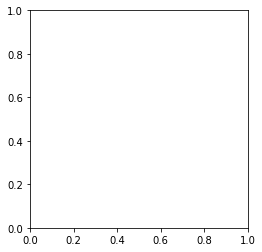

In [99]:
# PLOT IMAGE ##
train_img = x_test[8]
mask_img = y_test[8]
print(np.min(train_img), np.max(train_img))
plt.imshow(train_img)
plt.show()

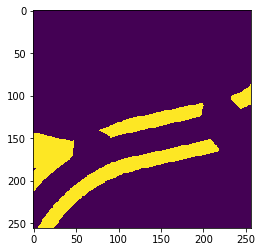

In [119]:
## PLOT MASK ##
mask_img = mask_img.reshape(256,256)
plt.imshow(mask_img)
plt.show()

In [128]:
for i in range(len(x_test)):
    j = i+1
    image = x_test[i:j]
    filename = filenames[i:j][0]
    prediction = loaded_model.predict(image, batch_size = 32)
    prediction = np.squeeze(prediction, axis = 0)
    cr.writeGeoTiff(json_path, prediction, filename, geotiff_folder)

In [22]:
#cr.vectorizePrediction(geotiff_folder, cat = 'bgt_gras_prob90', prob_treshold = 0.9)
#cr.vectorizePrediction(geotiff_folder, cat = 'bgt_gras_prob75', prob_treshold = 0.75)
#cr.vectorizePrediction(geotiff_folder, cat = 'bgt_gras6channels_prob25', prob_treshold = 0.25)
cr.vectorizePrediction(geotiff_folder, cat = 'GrasFromVegScanner_prob50', prob_treshold = 0.50)

In [9]:
filenames

['0_2016_h5130',
 '100_2016_h5130',
 '101_2016_h5130',
 '102_2016_h5130',
 '103_2016_h5130',
 '104_2016_h5130',
 '105_2016_h5130',
 '106_2016_h5130',
 '107_2016_h5130',
 '108_2016_h5130',
 '109_2016_h5130',
 '10_2016_h5130',
 '110_2016_h5130',
 '111_2016_h5130',
 '112_2016_h5130',
 '113_2016_h5130',
 '114_2016_h5130',
 '115_2016_h5130',
 '116_2016_h5130',
 '117_2016_h5130',
 '118_2016_h5130',
 '119_2016_h5130',
 '11_2016_h5130',
 '120_2016_h5130',
 '121_2016_h5130',
 '122_2016_h5130',
 '123_2016_h5130',
 '124_2016_h5130',
 '125_2016_h5130',
 '126_2016_h5130',
 '127_2016_h5130',
 '128_2016_h5130',
 '129_2016_h5130',
 '12_2016_h5130',
 '130_2016_h5130',
 '131_2016_h5130',
 '132_2016_h5130',
 '133_2016_h5130',
 '134_2016_h5130',
 '135_2016_h5130',
 '136_2016_h5130',
 '137_2016_h5130',
 '138_2016_h5130',
 '139_2016_h5130',
 '13_2016_h5130',
 '14_2016_h5130',
 '15_2016_h5130',
 '16_2016_h5130',
 '17_2016_h5130',
 '18_2016_h5130',
 '19_2016_h5130',
 '1_2016_h5130',
 '20_2016_h5130',
 '21_201

In [ ]:
# SHOW RESULTS ON TEST SET --> OUD --> NOT GEOTIFF

import scipy
predictions = loaded_model.predict(x_test, batch_size = 4)
predictions = predictions[0:20]

for i in range(len(predictions)):
    pred =  predictions[i].reshape(512,512)
    img = x_test[i]
    gt = y_test[i].reshape(512,512)

    scipy.misc.imsave(geotiff_folder + '/Test_img_' +str(i)+".tif", img)
    scipy.misc.imsave(geotiff_folder + '/Test_gt_' + str(i)+".tif", gt)
    scipy.misc.imsave(geotiff_folder + '/Test_prediction_'+str(i)+".tif", pred)